# SCGEN:  Batch-Removal

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../")

%matplotlib inline

In [2]:
import logging
import os
import pickle
import scanpy
import anndata
import scvi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import scanpy as sc
import os
import numpy as np
from scvi.data import synthetic_iid, transfer_anndata_setup, setup_anndata
from scgen import SCGEN

In [3]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)

### Loading Train Data

In [4]:
train = sc.read("./tests/data/pancreas.h5ad",
                backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1")


  0%|          | 0.00/176M [00:00<?, ?B/s]

/home/marco/.pyenv/versions/scgen_test/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/marco/.pyenv/versions/scgen_test/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata

In [5]:
train.obs["cell_type"] = train.obs["celltype"].tolist()
sc.pp.neighbors(train)
sc.tl.umap(train)

... storing 'cell_type' as categorical


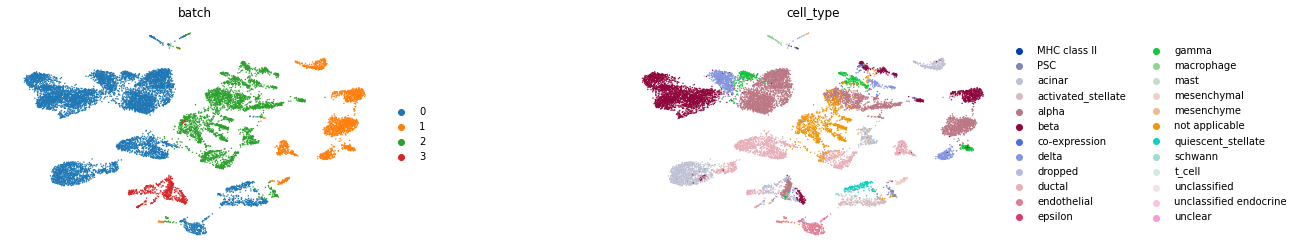

In [6]:
sc.pl.umap(train, color=["batch", "cell_type"], wspace=.5, frameon=False)

### Preprocessing Data

In [7]:
train = scvi.data.setup_anndata(train, copy=True)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
WARNING  This dataset has some empty cells, this might fail inference.Data should be filtered
         with `scanpy.pp.filter_cells()`                                                     
INFO     Successfully registered anndata object containing 14693 cells, 2448 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/marco/.pyenv/versions/scgen_test/lib/python3.7/site-packages/scvi/data/_anndata.py:815: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc
/home/marco/.pyenv/versions/scgen_test/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Creating and Saving the model¶

In [8]:
model = SCGEN(train)
model.save("../saved_models/model_batch_removal.pt", overwrite=True)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


## Training the Model

In [9]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    use_gpu=True
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [04:03<00:00,  2.43s/it, loss=670, v_num=1]


## Batch-Removal 

In [10]:
corrected_adata = model.batch_removal(train, batch_key="batch", cell_label_key="cell_type")

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/marco/.pyenv/versions/scgen_test/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Visualization of the corrected gene expression data¶

In [11]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'celltype' as categorical
... storing 'sample' as categorical
... storing 'batch' as categorical
... storing 'louvain' as categorical
... storing 'cell_type' as categorical


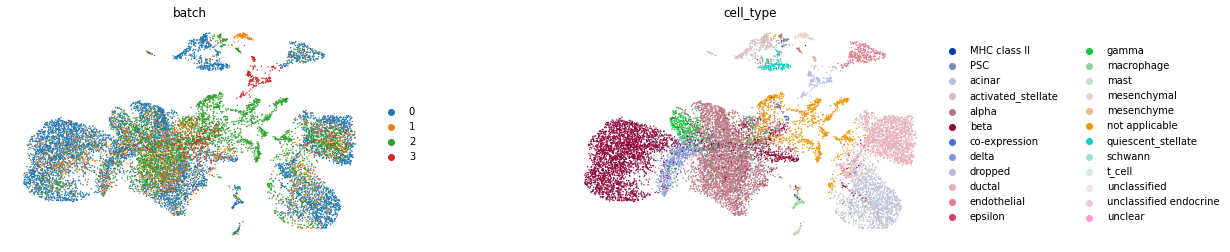

In [12]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False,
           save='_batch_corrected_b32_klw000005_z100__100pdf'
)

### Using Uncorrected Data

Note that original adata.raw for the adata.raw is saved to corrected_adata.raw and you can use that for fruther analaysis

In [13]:
corrected_adata.raw

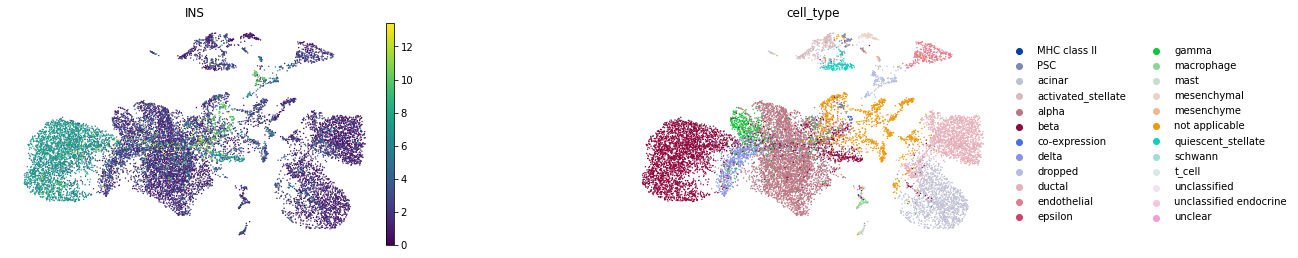

In [14]:
sc.pl.umap(corrected_adata, color=["INS", "cell_type"], wspace=.5, frameon=False, use_raw=True)
